In [1]:
#!pip install torch 

#!pip install --upgrade --force-reinstall nltk

#!pip install transformers==4.28.1
#!pip install sentence-transformers==2.2.2
#!pip install huggingface_hub==0.13.4
#!pip install deepspeed
#!pip install sentencepiece
#!pip install kaggle pandas

#!pip install pandas numpy seaborn matplotlib plotly scikit-learn wordcloud

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
from sentence_transformers import SentenceTransformer


### Initial Data Import (Modified To Equalize Grouping)

- Note selecting more then 10,000 rows, so that it can be filtered down so each category has ~1000

In [3]:
df = pd.read_json("arxiv_data/arxiv-metadata-oai-snapshot.json", lines=True, nrows=150000)


### PreProcessing

- All preprocessing code placed within one block to be easily run and then minimized

In [4]:
category_map = {
    'astro-ph': 'Astrophysics',
    'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
    'astro-ph.EP': 'Earth and Planetary Astrophysics',
    'astro-ph.GA': 'Astrophysics of Galaxies',
    'astro-ph.HE': 'High Energy Astrophysical Phenomena',
    'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
    'astro-ph.SR': 'Solar and Stellar Astrophysics',
    'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
    'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
    'cond-mat.mtrl-sci': 'Materials Science',
    'cond-mat.other': 'Other Condensed Matter',
    'cond-mat.quant-gas': 'Quantum Gases',
    'cond-mat.soft': 'Soft Condensed Matter',
    'cond-mat.stat-mech': 'Statistical Mechanics',
    'cond-mat.str-el': 'Strongly Correlated Electrons',
    'cond-mat.supr-con': 'Superconductivity',
    'cs.AI': 'Artificial Intelligence',
    'cs.AR': 'Hardware Architecture',
    'cs.CC': 'Computational Complexity',
    'cs.CE': 'Computational Engineering, Finance, and Science',
    'cs.CG': 'Computational Geometry',
    'cs.CL': 'Computation and Language',
    'cs.CR': 'Cryptography and Security',
    'cs.CV': 'Computer Vision and Pattern Recognition',
    'cs.CY': 'Computers and Society',
    'cs.DB': 'Databases',
    'cs.DC': 'Distributed, Parallel, and Cluster Computing',
    'cs.DL': 'Digital Libraries',
    'cs.DM': 'Discrete Mathematics',
    'cs.DS': 'Data Structures and Algorithms',
    'cs.ET': 'Emerging Technologies',
    'cs.FL': 'Formal Languages and Automata Theory',
    'cs.GL': 'General Literature',
    'cs.GR': 'Graphics',
    'cs.GT': 'Computer Science and Game Theory',
    'cs.HC': 'Human-Computer Interaction',
    'cs.IR': 'Information Retrieval',
    'cs.IT': 'Information Theory',
    'cs.LG': 'Machine Learning',
    'cs.LO': 'Logic in Computer Science',
    'cs.MA': 'Multiagent Systems',
    'cs.MM': 'Multimedia',
    'cs.MS': 'Mathematical Software',
    'cs.NA': 'Numerical Analysis',
    'cs.NE': 'Neural and Evolutionary Computing',
    'cs.NI': 'Networking and Internet Architecture',
    'cs.OH': 'Other Computer Science',
    'cs.OS': 'Operating Systems',
    'cs.PF': 'Performance',
    'cs.PL': 'Programming Languages',
    'cs.RO': 'Robotics',
    'cs.SC': 'Symbolic Computation',
    'cs.SD': 'Sound',
    'cs.SE': 'Software Engineering',
    'cs.SI': 'Social and Information Networks',
    'cs.SY': 'Systems and Control',
    'econ.EM': 'Econometrics',
    'eess.AS': 'Audio and Speech Processing',
    'eess.IV': 'Image and Video Processing',
    'eess.SP': 'Signal Processing',
    'gr-qc': 'General Relativity and Quantum Cosmology',
    'hep-ex': 'High Energy Physics - Experiment',
    'hep-lat': 'High Energy Physics - Lattice',
    'hep-ph': 'High Energy Physics - Phenomenology',
    'hep-th': 'High Energy Physics - Theory',
    'math.AC': 'Commutative Algebra',
    'math.AG': 'Algebraic Geometry',
    'math.AP': 'Analysis of PDEs',
    'math.AT': 'Algebraic Topology',
    'math.CA': 'Classical Analysis and ODEs',
    'math.CO': 'Combinatorics',
    'math.CT': 'Category Theory',
    'math.CV': 'Complex Variables',
    'math.DG': 'Differential Geometry',
    'math.DS': 'Dynamical Systems',
    'math.FA': 'Functional Analysis',
    'math.GM': 'General Mathematics',
    'math.GN': 'General Topology',
    'math.GR': 'Group Theory',
    'math.GT': 'Geometric Topology',
    'math.HO': 'History and Overview',
    'math.IT': 'Information Theory',
    'math.KT': 'K-Theory and Homology',
    'math.LO': 'Logic',
    'math.MG': 'Metric Geometry',
    'math.MP': 'Mathematical Physics',
    'math.NA': 'Numerical Analysis',
    'math.NT': 'Number Theory',
    'math.OA': 'Operator Algebras',
    'math.OC': 'Optimization and Control',
    'math.PR': 'Probability',
    'math.QA': 'Quantum Algebra',
    'math.RA': 'Rings and Algebras',
    'math.RT': 'Representation Theory',
    'math.SG': 'Symplectic Geometry',
    'math.SP': 'Spectral Theory',
    'math.ST': 'Statistics Theory',
    'math-ph': 'Mathematical Physics',
    'nlin.AO': 'Adaptation and Self-Organizing Systems',
    'nlin.CD': 'Chaotic Dynamics',
    'nlin.CG': 'Cellular Automata and Lattice Gases',
    'nlin.PS': 'Pattern Formation and Solitons',
    'nlin.SI': 'Exactly Solvable and Integrable Systems',
    'nucl-ex': 'Nuclear Experiment',
    'nucl-th': 'Nuclear Theory',
    'physics.acc-ph': 'Accelerator Physics',
    'physics.ao-ph': 'Atmospheric and Oceanic Physics',
    'physics.app-ph': 'Applied Physics',
    'physics.atm-clus': 'Atomic and Molecular Clusters',
    'physics.atom-ph': 'Atomic Physics',
    'physics.bio-ph': 'Biological Physics',
    'physics.chem-ph': 'Chemical Physics',
    'physics.class-ph': 'Classical Physics',
    'physics.comp-ph': 'Computational Physics',
    'physics.data-an': 'Data Analysis, Statistics and Probability',
    'physics.ed-ph': 'Physics Education',
    'physics.flu-dyn': 'Fluid Dynamics',
    'physics.gen-ph': 'General Physics',
    'physics.geo-ph': 'Geophysics',
    'physics.hist-ph': 'History and Philosophy of Physics',
    'physics.ins-det': 'Instrumentation and Detectors',
    'physics.med-ph': 'Medical Physics',
    'physics.optics': 'Optics',
    'physics.plasm-ph': 'Plasma Physics',
    'physics.pop-ph': 'Popular Physics',
    'physics.soc-ph': 'Physics and Society',
    'physics.space-ph': 'Space Physics',
    'q-bio.BM': 'Biomolecules',
    'q-bio.CB': 'Cell Behavior',
    'q-bio.GN': 'Genomics',
    'q-bio.MN': 'Molecular Networks',
    'q-bio.NC': 'Neurons and Cognition',
    'q-bio.OT': 'Other Quantitative Biology',
    'q-bio.PE': 'Populations and Evolution',
    'q-bio.QM': 'Quantitative Methods',
    'q-bio.SC': 'Subcellular Processes',
    'q-bio.TO': 'Tissues and Organs',
    'q-fin.CP': 'Computational Finance',
    'q-fin.EC': 'Economics',
    'q-fin.GN': 'General Finance',
    'q-fin.MF': 'Mathematical Finance',
    'q-fin.PM': 'Portfolio Management',
    'q-fin.PR': 'Pricing of Securities',
    'q-fin.RM': 'Risk Management',
    'q-fin.ST': 'Statistical Finance',
    'q-fin.TR': 'Trading and Market Microstructure',
    'quant-ph': 'Quantum Physics',
    'stat.AP': 'Applications',
    'stat.CO': 'Computation',
    'stat.ME': 'Methodology',
    'stat.ML': 'Machine Learning',
    'stat.OT': 'Other Statistics',
    'stat.TH': 'Statistics Theory'
}

subject_map = {
    "Astrophysics & Cosmology": ["astro-ph", "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE", "astro-ph.IM", "astro-ph.SR"],
    "Condensed Matter Physics": ["cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci", "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft", "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"],
    "Computer Science": ["cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV", "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL", "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO", "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS", "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"],
    "Econometrics & Finance": ["econ.EM", "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR", "q-fin.RM", "q-fin.ST", "q-fin.TR"],
    "Electrical Engineering & Signal Processing": ["eess.AS", "eess.IV", "eess.SP"],
    "General & Theoretical Physics": ["gr-qc", "hep-ex", "hep-lat", "hep-ph", "hep-th", "math-ph", "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus", "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph", "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn", "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det", "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph", "physics.soc-ph", "physics.space-ph", "quant-ph"],
    "Mathematics": ["math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO", "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM", "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT", "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA", "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG", "math.SP", "math.ST"],
    "Nonlinear Sciences": ["nlin.AO", "nlin.CD", "nlin.CG", "nlin.PS", "nlin.SI"],
    "Nuclear Physics": ["nucl-ex", "nucl-th"],
    "Quantitative Biology": ["q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT", "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"],
    "Statistics & Data Science": ["stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"]
}

# If there are multiple categories associated with the document, take the first one
df['categories'] = df['categories'].str.split().str[0]

# Add subjects instead of the category
category_to_subject = {}
for subject, categories in subject_map.items():
    for category in categories:
        category_to_subject[category] = subject

# Apply the corrected mapping
df['mapped_categories'] = df['categories'].map(category_map)
df['subject_map'] = df['categories'].map(category_to_subject)
df['mapped_categories'] = df['mapped_categories'].fillna('Unknown Category') #should not exist
df['subject_map'] = df['subject_map'].fillna('Unknown Subject')  #should not exist

# Print unique subject mappings (ie. without duplicates)
df[['categories', 'mapped_categories', 'subject_map']].drop_duplicates().head(5)



# Drop rows where 'title' or 'abstract' are missing
df_cleaned = df.dropna(subset=['title', 'abstract'])

# Function to clean text
def clean_text(text):
    # Remove extra spaces and special characters
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

# Apply text cleaning to 'title' and 'abstract' columns
df_cleaned['title'] = df_cleaned['title'].apply(clean_text)
df_cleaned['abstract'] = df_cleaned['abstract'].apply(clean_text)

# Remove duplicate rows based on 'title' and 'abstract'
df_cleaned = df_cleaned.drop_duplicates(subset=['title', 'abstract'])

# Convert the update date to a proper datetime format
df_cleaned['update_date'] = pd.to_datetime(df_cleaned['update_date'], errors='coerce')

# Extract the year from the update date
df_cleaned['year'] = df_cleaned['update_date'].dt.year

# Exclude rows where the category is "Unknown Category"
df_cleaned = df_cleaned[df_cleaned['mapped_categories'] != 'Unknown Category']

"""
Reformats Author Data Into Clean List
"""
def clean_contributors(author_string):

    #Remove Anything In Brackets
    s = re.sub(r'\([^)]*\)', '', author_string)

    #Remove All "and"
    s = re.sub(r'\band\b', '', s, flags=re.IGNORECASE)

    #Remove All "\n"
    s = s.replace('\n', '') 

    #Split And Trim
    return [part.strip() for part in s.split(',') if part.strip()]
    
#Cleans The Author Columns
df_cleaned['authors_parsed'] = df_cleaned['authors'].apply(clean_contributors)
df_cleaned = df_cleaned.drop(columns='authors')

#Store Count
df_cleaned['contributors'] = df['authors_parsed'].apply(len)

#Order 
df_cleaned = df_cleaned.sort_values(by='id')

### Initial Data Filtering

- Keeping a more equally category distributed subset of rows equalling ~10,000

In [ ]:
#Counting Categories
key_categories = df_cleaned['subject_map'].nunique()

#Counting Sample Per Category We Want
samples_per_category = int(10000 / key_categories)

#Selecting These Samples
df_cleaned = (
    df_cleaned.groupby('subject_map')
      .apply(lambda x: x.sample(n=min(samples_per_category, len(x)), random_state=42))
      .reset_index(drop=True)
)

C:\Users\ldunc\AppData\Local\Temp\ipykernel_12320\2040230402.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(samples_per_category, len(x)), random_state=42))


,id,submitter,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,mapped_categories,subject_map,year,contributors
0,806.4346,Pavel Denissenkov,magnetothermohaline mixing in red giants,"31 pages, 4 figures, 2 tables, accepted by ApJ...","Astrophys.J.696:1823-1833,2009",10.1088/0004-637X/696/2/1823,None,astro-ph,http://arxiv.org/licenses/nonexclusive-distrib...,we revise a magnetic buoyancy model that has ...,"[{'version': 'v1', 'created': 'Thu, 26 Jun 200...",2011-02-11,"[Pavel A. Denissenkov, Marc Pinsonneault, Keit...",Astrophysics,Astrophysics & Cosmology,2011,3
1,908.2971,Lisa May Walker,midinfrared evidence for accelerated evolution...,To appear in the Proceedings of the Galaxy War...,ASPC 423 (2010) 88,None,None,astro-ph.CO,http://arxiv.org/licenses/nonexclusive-distrib...,we find evidence for accelerated evolution in...,"[{'version': 'v1', 'created': 'Thu, 20 Aug 200...",2010-08-26,"[Lisa May Walker, Kelsey E. Johnson, Sarah C. ...",Cosmology and Nongalactic Astrophysics,Astrophysics & Cosmology,2010,7
2,709.1158,Eli Rykoff,measuring the mean and scatter of the xray lum...,"21 pages, 12 figures, revised after referee's ...","Astrophys.J.675:1106-1124,2008",10.1086/527537,None,astro-ph,None,determining the scaling relations between gal...,"[{'version': 'v1', 'created': 'Fri, 7 Sep 2007...",2010-11-11,"[E. S. Rykoff, T. A. McKay, M. R. Becker, A. ...",Astrophysics,Astrophysics & Cosmology,2010,9
3,805.3413,Richard Wilman,a semiempirical simulation of the extragalacti...,15 pages; to appear in MNRAS,"Mon.Not.Roy.Astron.Soc.388:1335-1348,2008",10.1111/j.1365-2966.2008.13486.x,None,astro-ph,http://arxiv.org/licenses/nonexclusive-distrib...,we have developed a semiempirical simulation ...,"[{'version': 'v1', 'created': 'Thu, 22 May 200...",2010-11-09,"[R. J. Wilman, L. Miller, M. J. Jarvis, T. Mau...",Astrophysics,Astrophysics & Cosmology,2010,11
4,902.3280,Matthew Povich,the extended environment of m17 a star formati...,"31 pages, 15 figures, accepted for publication...","Astrophys.J.696:1278-1306,2009",10.1088/0004-637X/696/2/1278,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,m17 is one of the youngest and most massive n...,"[{'version': 'v1', 'created': 'Thu, 19 Feb 200...",2011-02-11,"[Matthew S. Povich, Ed Churchwell, John H. Bie...",Astrophysics of Galaxies,Astrophysics & Cosmology,2011,12


### Category Distribution
- Note the more equal distribution of Subjects (although not in categories)

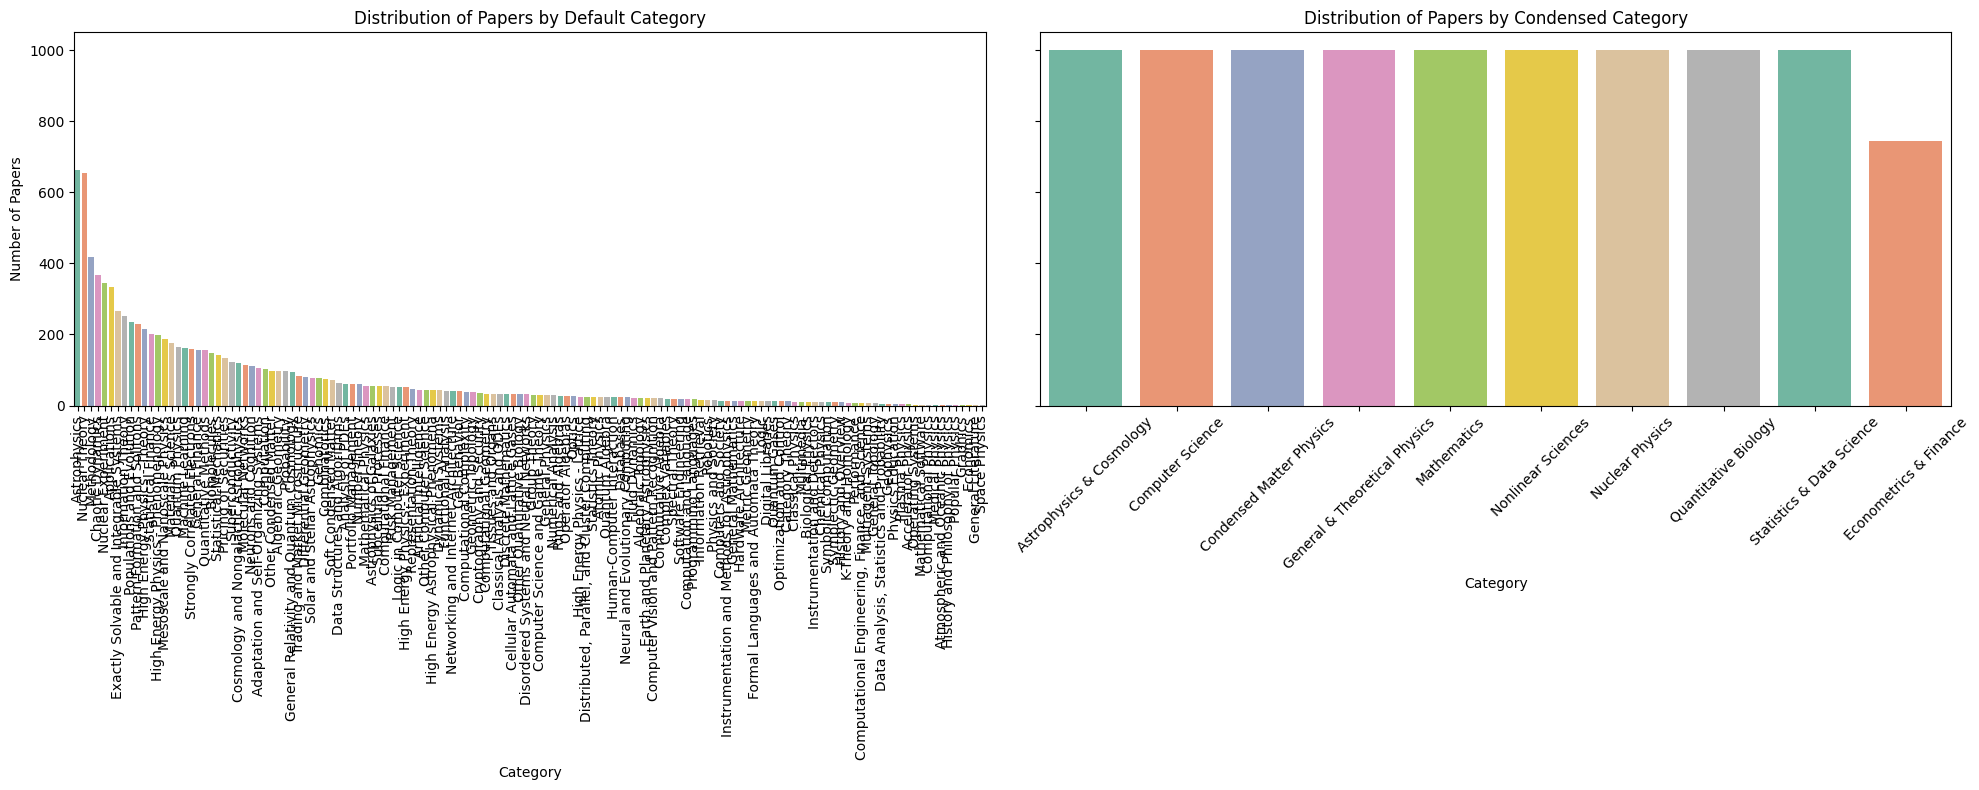

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Count categories
counts_orig = df_cleaned['mapped_categories'].value_counts().reset_index()
counts_orig.columns = ['Category', 'Count']

counts_cond = df_cleaned['subject_map'].value_counts().reset_index()
counts_cond.columns = ['Category', 'Count']

# Plot original categories with hue workaround
sns.barplot(data=counts_orig,x='Category',y='Count',hue='Category',palette='Set2',legend=False,ax=axes[0])
axes[0].set_title('Distribution of Papers by Default Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Papers')
axes[0].tick_params(axis='x', rotation=90)

# Plot condensed categories with hue workaround
sns.barplot(data=counts_cond,x='Category',y='Count', hue='Category',palette='Set2',legend=False,ax=axes[1])
axes[1].set_title('Distribution of Papers by Condensed Category')
axes[1].set_xlabel('Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Embedding

- Below is code to utilize both BERT embedding, and 

In [7]:
#Models Used
model_full_bert = 'bert-base-uncased'
model_sentence = 'all-MiniLM-L6-v2'

#Tokenizers And Models Required
full_tokenizer = BertTokenizer.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
full_model = BertModel.from_pretrained(model_full_bert, ignore_mismatched_sizes=True)
sentence_model = SentenceTransformer(model_sentence)

"""
Your Original Method: Averaging Word Embeddings, Better For Finding Keyword Similarity
"""
def original_token_embedding(text):

        inputs = full_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

        with torch.no_grad(): outputs = full_model(**inputs)

        embeddings = outputs.last_hidden_state.mean(dim=1)

        return embeddings.numpy().flatten()

"""
Generates Embedding According To Chosen Method
"""
def generate_embeddings(method, applied_on):
        if method == "token":
                return applied_on.apply(original_token_embedding)
        else:
                return list(sentence_model.encode(applied_on.tolist(), batch_size=128, show_progress_bar=True))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
df_cleaned['title_embeddings'] = generate_embeddings('token', df_cleaned['title'])
df_cleaned['abstract_embeddings'] = generate_embeddings('token', df_cleaned['abstract'])

KeyboardInterrupt: 

### NOTE: Generating Alternative Method

- So the previous embedding is based on language models, whats below is very similar but puts the embedding through a layer to incorporate tendencies for co-authorship and category overlap among authors
- To do this, I start by making 2 new dataframes, one (df_contributions) to represent an authors contribution to a single paper, and a second (df_authors) to store aggregate information about each author
- Some information is then merged, which is redundant space wise, but makes the code easier

In [ ]:
df_contributions = (
    df_cleaned
    .assign(
        contributors = df_cleaned["authors_parsed"].apply(len)
    )
    .explode("authors_parsed", ignore_index=True)
    .rename(columns={"authors_parsed":"contributor"})
    .assign(
        is_lead = lambda d: d.apply(lambda row: any(w.lower() in re.split(r'[^A-Za-z]+', row['contributor'].lower()) for w in re.split(r'[^A-Za-z]+', row['submitter'].lower())), axis=1)
    )
    .loc[:, lambda d: ~d.columns.isin(["authors_parsed","unclean_contributor", "submitter", "authors", "comments", "journal-ref", "doi", "license", "versions", "update_date", "report-no", "categories", "title", "abstract"])]
)

df_authors = (
    df_contributions
    .groupby("contributor")
    .agg(
        papers = ('id', 'count'),
        earliest = ('year', 'min'),
        latest = ('year', 'max'),
        solo = ('contributors', lambda x: (x==1).sum()),
        average_size = ('contributors', 'mean'),
        mapped_category_count = ('mapped_categories', lambda x: x.dropna().nunique()),
        subject_map_count = ('subject_map', lambda x: x.dropna().nunique())
    )
    .reset_index()
)
df_authors.head(1)

df_contributions = df_contributions.merge(df_authors[['contributor', 'earliest', 'latest', 'papers']], on='contributor', how='left')
paper_sums = df_contributions.groupby('id')['papers'].sum().reset_index(name='total_papers')
df_cleaned = df_cleaned.merge(paper_sums, on='id', how='left')

In [ ]:
"""
Generates The Average Embeddings For A Category Using The Weighted Papers Within It
"""
def paper_contribution_to_category(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis = 0,
        weights = np.sqrt(group['contributors'].values) * #Use Contributor
                  np.sqrt(group['total_papers']/group['contributors']) #Higher Publishing experience
    )

"""
Generates The Average Author Embedding Using Weighted Papers They Contributed To
"""
def paper_contribution_to_author(group,chosen_embedding):
    
    duration = np.maximum(group['latest']-group['earliest'],1)
    point_within = group['year']-group['earliest']

    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  np.log(point_within/duration + 2)*   #Use Point In Career
                   ( 1 + group['is_lead']*3 ) *   #Role In Paper
                  (np.power(1 / group['contributors'], 0.5))  # Inverse Contributors 
    )


"""
Generates The Average Paper Embedding Usings Weighted Authors That Contributed To It
"""
def authors_contribution_to_paper(group, chosen_embedding):
    return np.average(
        np.stack(group[chosen_embedding].values),
        axis=0,
        weights=  ( 1 + group['is_lead']*3 ) * #More If Author Leading It
                    np.sqrt(group['papers']) * #Move If Many Papers Made
                    (1 - 0.9 * (group['papers'] == 1)) #Less If This Is Only Paper Made By Author (Dilutes)
    )

### NOTE: Generating New Embeddings

- Can then apply these methods to generate alternative embeddings, allowing user to specify their desired base embedding to use (important if we are comparing methods)

In [ ]:
""""
A Method That Generates An Alternative Embedding For A Paper, By Generating An Embedding For Each Author, Then Aggregating Each Papers Contributors Embeddings
"""
def generate_alternative_embeddings(chosen_embeddings, contributions):

    #Generate Author Embedding
    author_embeddings = (
        contributions
        .groupby('contributor')
        .apply(lambda group: paper_contribution_to_author(group,chosen_embeddings), include_groups=False)
        .reset_index(name = "author_" + chosen_embeddings)
    )

    #Merge To Join This Data
    contributions = contributions.merge(author_embeddings, on='contributor', how='left')

    #Generate New Paper Embedding
    alternative_embeddings = (
        contributions
        .groupby('id')
        .apply(lambda group: authors_contribution_to_paper(group, "author_" + chosen_embeddings), include_groups=False)
        .sort_index()
        .reset_index(name= "alternative_" + chosen_embeddings)
    )

    #Returning New Embedding
    return list(alternative_embeddings["alternative_" + chosen_embeddings])

### NOTE: Generating New Embeddings

- In addition to the 2 initial embeddings you had, added the joined version I added above

- ALTERNATIVE COMBOS CAN BE TRIED

In [ ]:
df_cleaned['alternative_title_embeddings'] =    generate_alternative_embeddings( chosen_embeddings="title_embeddings",    contributions=df_contributions)
df_cleaned['alternative_abstract_embeddings'] = generate_alternative_embeddings(chosen_embeddings="abstract_embeddings", contributions=df_contributions)

### Category Similarity Comparison
This code computes and visualizes the similarity between research paper categories based on their title and abstract embeddings. The function CompareAll calculates the mean similarity between categories by comparing each paper in one category to its most similar papers in another category, using a precomputed similarity matrix.

The function iterates through all category pairs and finds the most similar articles across categories. It then computes an average similarity score for each category pair and stores the results in a difference matrix. The diagonal values, representing self-comparisons, are set to zero initially but later replaced with NaN for better visualization.

A heatmap is then generated to display these similarity differences, using a color gradient to indicate how closely related different research categories are. This visualization helps identify relationships between research areas, revealing clusters of related topics.

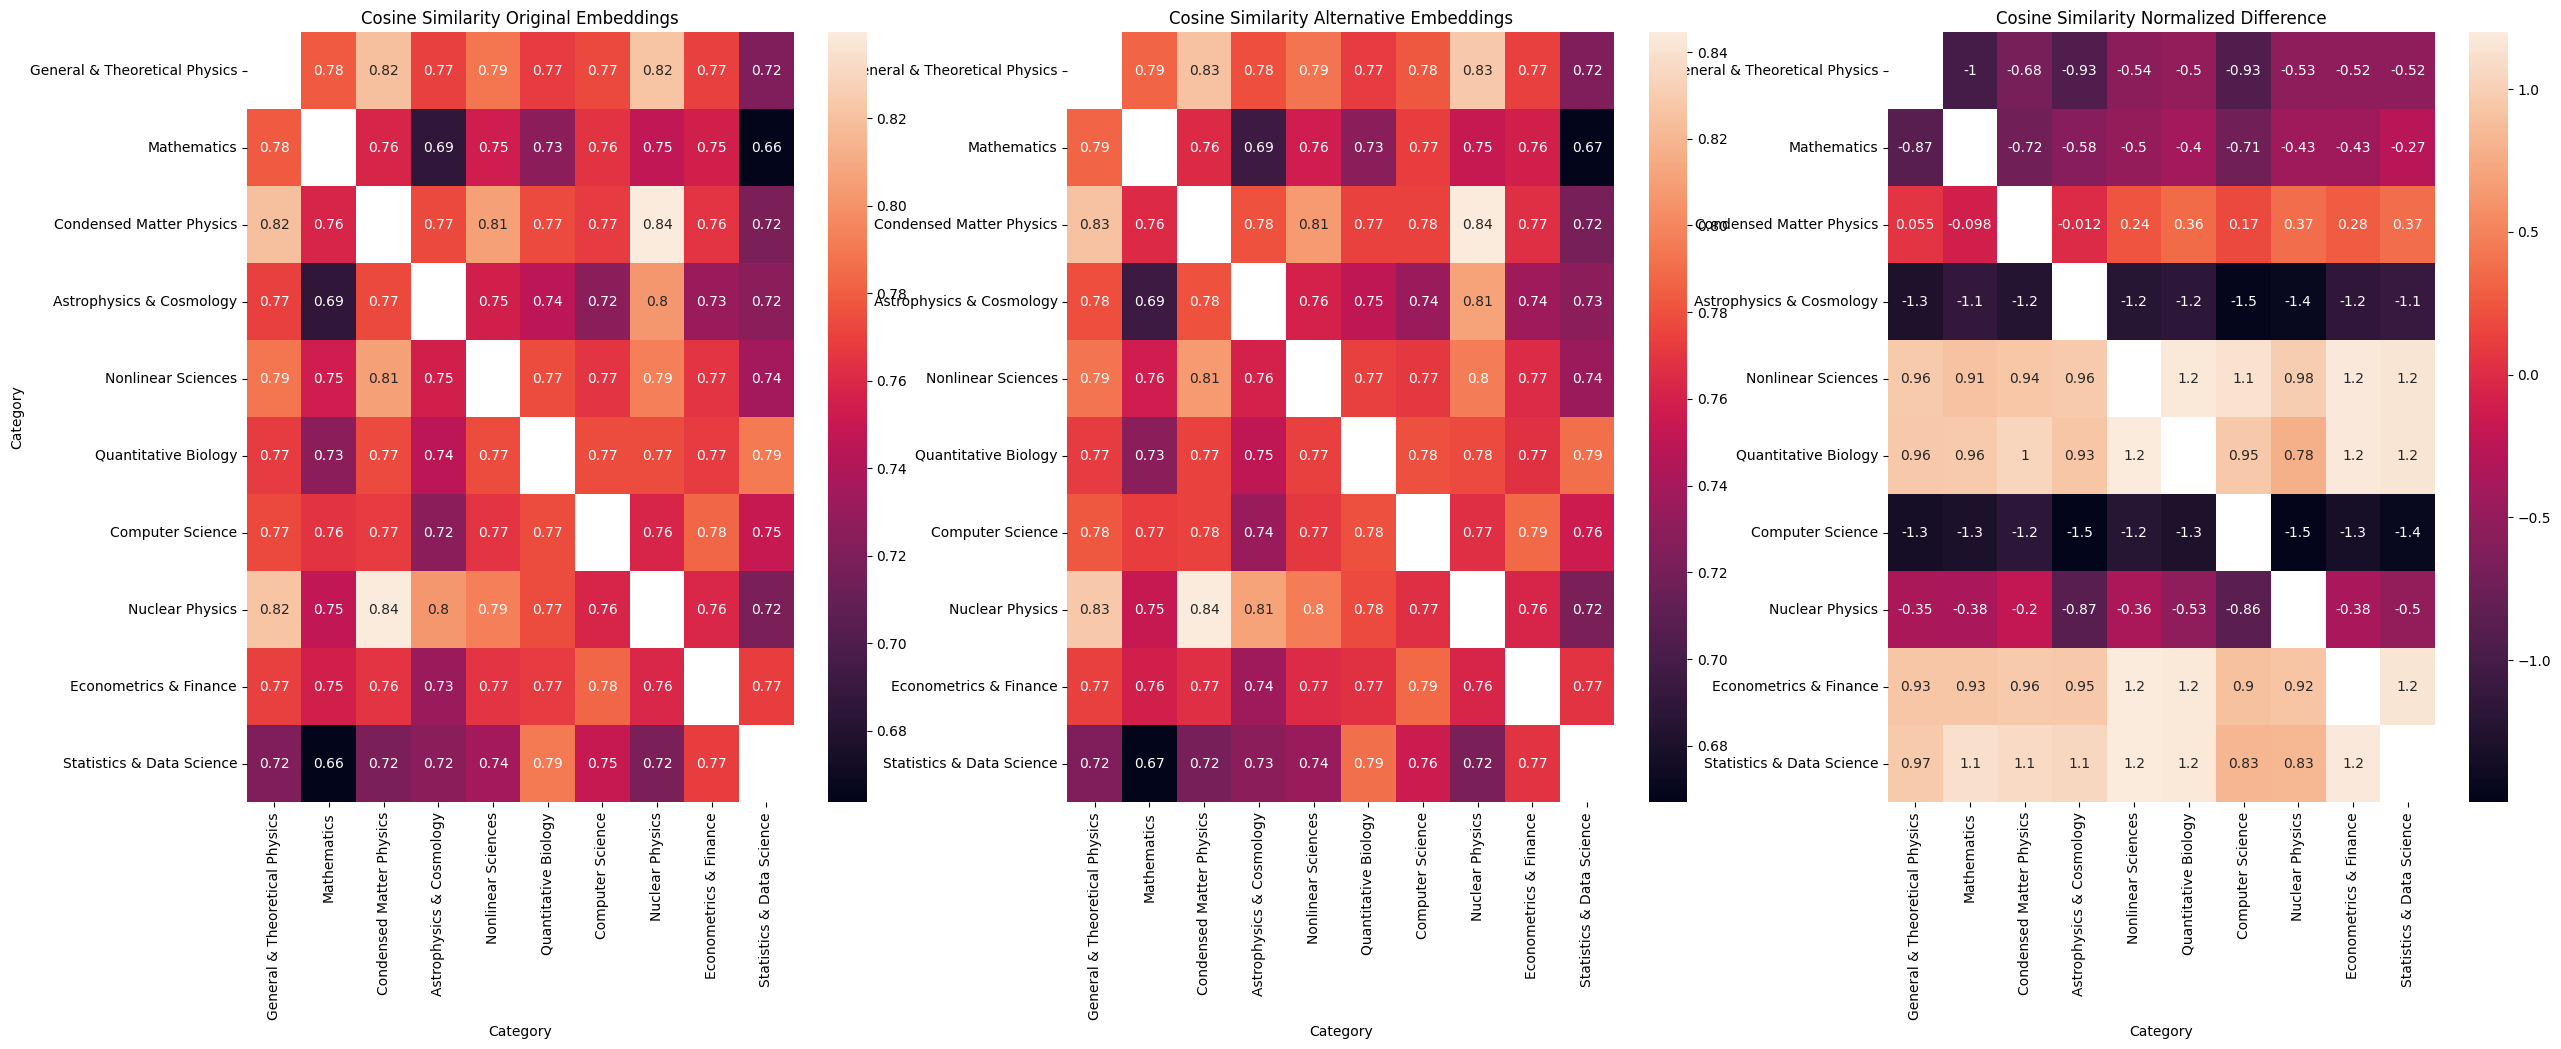

In [ ]:

def create_similarity_matrix(title_col, abstract_col, df):
    # Combine title and abstract embeddings
    combined = 0.5 * (df[title_col] + df[abstract_col])
    sim_matrix = cosine_similarity(np.stack(combined))
    
    cats = df['subject_map'].unique()
    cat_sim = np.zeros((len(cats), len(cats)))
    
    for i, c1 in enumerate(cats):
        i1 = df['subject_map'] == c1
        for j, c2 in enumerate(cats):
            i2 = df['subject_map'] == c2
            cat_sim[i, j] = sim_matrix[np.ix_(i1, i2)].mean()

    np.fill_diagonal(cat_sim, np.nan)

    return pd.DataFrame(cat_sim, index=cats, columns=cats)



def plot_similarity_matrix(ax, similarity, title):
    sns.heatmap(similarity, ax=ax, annot=True)
    ax.set_title("Cosine Similarity " + title)
    ax.set_xlabel("Category")
    ax.set_ylabel("Category")



fig, axes = plt.subplots(1,3, figsize=(30, 10))



#Original Method
original_method = create_similarity_matrix('title_embeddings', 'abstract_embeddings', df_cleaned)
plot_similarity_matrix(axes[0], original_method, "Original Embeddings")

#Alternative Method
alternative_method = create_similarity_matrix('alternative_title_embeddings', 'alternative_abstract_embeddings', df_cleaned)
plot_similarity_matrix(axes[1], alternative_method, "Alternative Embeddings")

#Normalized Differences
diff = original_method - alternative_method
diff = (diff - diff.mean()) / diff.std()
plot_similarity_matrix(axes[2], diff, "Normalized Difference")

plt.show()

In [ ]:
category_similarity_df = compute_combined_category_similarity_matrix('alternative_title_embeddings', 'alternative_abstract_embeddings', df_cleaned)

# Set diagonal to NaN to avoid self-similarity being shown
np.fill_diagonal(category_similarity_df.values, np.nan)

# Plot the heatmap for the category similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    category_similarity_df,
    cmap='YlGnBu',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    vmin=0.6,  # Set the minimum value for color scale
    vmax=1,  # Set the maximum value for color scale
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title("Cosine Similarity Matrix Between Categories (Alternative Combined Title & Abstract Embeddings)")
plt.xlabel("Category")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### NOTE: Category Similarity Comparison

- An Alternative Method That Allows Inputted Embeddings To Be used, with level of specificity (IE: subject_map vs categories)
- Method also makes use of above function to weigh each paper by above rules

In [ ]:
"""
Generates Group Based Embedding Average
"""
def aggregate_groups(df, embedding, categories):
    return (
        df
        .groupby(categories)
        .apply(lambda group: paper_contribution_to_category(group, embedding), include_groups=False)
        .reset_index(name='embeddings')
        .sort_values(by=categories)
    )


"""
Generates A Similarity Matrix
"""
def plot_similarity_matrix(ax, similarity, columns, title):
    visual = pd.DataFrame(similarity, index=columns, columns=columns)
    sns.heatmap(visual, ax=ax, annot=True)
    ax.set_title(title)

"""
Generates An (Optionally Normalized) Matrix To Display Differences In Similarity Between Categories Between Methods
"""
def comparing_embedding_similarity(df, embedding1, embedding2, categories, normalize=True):

    #Plotting Stuff
    fig, axes = plt.subplots(1,3, figsize=(30, 10))

    #Generating Grouped Embeddings
    grouped_embedding1 = aggregate_groups(df, embedding1, categories)
    grouped_embedding2 = aggregate_groups(df, embedding2, categories)

    cs1 = cosine_similarity(np.stack(grouped_embedding1['embeddings'].values))
    cs2 = cosine_similarity(np.stack(grouped_embedding2['embeddings'].values))

    #Groups
    columns =  grouped_embedding1[categories]

    plot_similarity_matrix(axes[0], cs1, columns, embedding1)
    plot_similarity_matrix(axes[1], cs2, columns, embedding2)


    #Difference In Similarity
    diff = cs1 - cs2

    #Optionally Normalize
    if normalize:
        diff = (diff - diff.mean()) / diff.std()

    plot_similarity_matrix(axes[2], diff, columns, "Normalized Difference")

    plt.plot()

### NOTE: Plotting Similarity Matrixs

- Comparing Methods (first sim, second sim, third normalized sim)

- ALTERNATIVE COMBOS CAN BE TRIED

In [ ]:
comparing_embedding_similarity(df_cleaned, 'alternative_joined_embeddings', "joined_embeddings", "subject_map")

### Paper Uniqueness Evaluation
This code computes and visualizes the uniqueness of research papers in different categories using similarity matrices based on their title and abstract embeddings. The function Uniqueness calculates how distinct a paper is by measuring its similarity to papers in different categories.

The function iterates through each paper and identifies the most similar papers from other categories. It then computes an average similarity score for these cross-category papers, which is used as a uniqueness score (higher similarity to other categories means lower uniqueness). These scores are stored in a new column, 'Uniquity', in df_cleaned.

The code then groups the uniqueness scores by subject and calculates the mean uniqueness score for each category. It generates bar charts to visualize the results, where lower scores indicate more unique subjects, and higher scores indicate greater overlap with other categories.

Importance:
- Assessing Paper Uniqueness: This metric provides insight into how distinct research papers are in terms of content, helping to identify which areas of research are more or less unique.
- Category Insights: The resulting visualizations show which research categories are more likely to overlap with others, which can guide further exploration of interdisciplinary research or highlight saturated topics.
- Enhanced Decision-Making: Understanding uniqueness can help researchers identify niches in the literature, potentially guiding future research into less-explored areas.

In [ ]:
def Uniqueness(similarity_matrix):
    uniquity_scores = []  # Store uniqueness scores for each index

    for j in range(len(similarity_matrix)):  # Iterate over all indices
        mapped = df_cleaned.iloc[j]['subject_map']
        similar_indices = [i for i in similarity_matrix[j].argsort()[::-1][1:]if df_cleaned.iloc[i]['subject_map'] != mapped]
        sumb= 0
        for i in similar_indices:
            suma = similarity_matrix[j][i]
            sumb += suma
        lena = len(similar_indices)
        uniquity = sumb / lena  # Compute uniqueness score

        uniquity_scores.append(uniquity)  # Store score
    df_cleaned['Uniquity'] = uniquity_scores  # Assign all scores to dataframe column
    return uniquity_scores

Uniqueness(title_sim_matrix)

category_colors = {category: color for category, color in zip(categories, palette)}
subject_colors = {subject: color for subject, color in zip(subjects, palette)}


# Group by 'Subject' and calculate mean uniqueness
subject_uniquity = df_cleaned.groupby('subject_map')['Uniquity'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=subject_uniquity.index, y=subject_uniquity.values, palette=subject_colors)
plt.xlabel('Average Uniquity Score (Lower is more Unique)')
plt.ylabel('Subject')
plt.title('Uniquity Score by Subject and Title')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()

Uniqueness(abstract_sim_matrix)

# Group by 'Subject' and calculate mean uniqueness
subject_uniquity = df_cleaned.groupby('subject_map')['Uniquity'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=subject_uniquity.index, y=subject_uniquity.values, palette=subject_colors)
plt.xlabel('Average Uniquity Score (Lower is more Unique)')
plt.ylabel('Subject')
plt.title('Uniquity Score by Subject and Abstract')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.show()